<a href="https://colab.research.google.com/github/VinylBr/Project_MTBResistance/blob/main/Project_184026002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Vinay Barnabas

# Import

In [ ]:
import pandas as pd
import numpy as np
import gdown #to download from gdrive
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
plt.rcParams.update({'font.size':18})
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Upload Datasets
----

In [ ]:
!gdown https://drive.google.com/uc?id=1-46hUwDdUhE9DGBAkx9gPx6FTvOSiV-c #Download from google drive TEST_LEV.csv

Downloading...
From: https://drive.google.com/uc?id=1-46hUwDdUhE9DGBAkx9gPx6FTvOSiV-c
To: /content/TEST_LEV.csv
100% 86.8M/86.8M [00:00<00:00, 159MB/s]


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1EfUa-VdQ1gPcDFtBxKGfh12rragoPr32/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1EfUa-VdQ1gPcDFtBxKGfh12rragoPr32
To: /content/DST_LEV.csv
100% 1.57M/1.57M [00:00<00:00, 15.7MB/s]


# Command line: Ubuntu executed using windows subsystem for Linux (WSL)

zcat MUTATIONS.csv.gz | awk -F',' '{ if (NF > max_fields) max_fields = NF } END { print max_fields }' *print the maximum field* <br>

zcat MUTATIONS.csv.gz | cut -d ',' -f 2 | tail -n +2 | sort | uniq > genes.txt *get the list of genes* <br>
<br>

zcat DST_MEASUREMENTS.csv.gz | grep "LEV" | grep "CRyPTIC" > DST_LEV.csv <br>
*Get only Drug Susceptibility testing (DST) data for Levofloxacin(LEV) measured by CRyPTIC consortium. Assumption no. 1* <br>

cat DST_LEV.csv | awk -F "," '{print $1}' | uniq  > SAMPLEID.csv
*get only sample IDs where Levofloxacin resistance has been tested* <br>
<br>


zcat MUTATIONS.csv.gz | grep -Fw -f SAMPLEID.csv | gzip > MUTATIONS_redacted.csv.gz *reduce the Mutations dataset* <br>


zcat MUTATIONS_redacted.csv.gz | awk -F "," '{print $1","$2}' | uniq | awk -F',' 'NR>1{genes[$1] = genes[$1] "," $2} END {for (sample in genes) print sample","substr(genes[sample], 2)}' > DATAMATRIX_LEV.csv <br>

*takes only SAMPLEID and Gene names, gets unique values, creates a csv with rows as SAMPLEID and columns as genes*<br>
<br>
<br>

DATAMATRIX_LEV.csv has 11,183 samples <br>
Maximum number of mutated genes in a sample 1544. This is lower than the total number of genes which is around 3862 <br>


zcat DSTMEASUREMENTS.csv.gz | awk -F "," '{print $1","$NF}' | awk -F',' 'NR>1{res[$1] = res[$1] "," $2} END {for (sample in res) print sample","substr(res[sample], 2)}' > RESISTANCESTATUS.csv <br>


IN DST_measurement for LEV with CRyPTIC consortium dataset = 15,224 samples <br>
for LEV alone there were around 20,668 samples <br>
using LEV + CRyPTIC dataset <br>


In [ ]:
df = pd.read_csv("TEST_LEV.csv")
Resistance_status_df = pd.read_csv("DST_LEV.csv")

In [ ]:
df.head()

,SAMPLEID,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,...,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c
0,site.03.subj.GB-83750038.lab.83750038.iso.1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Resistance_status_df.head()

,UNIQUEID,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE
0,site.10.subj.ATCC17052017.lab.ATCC17052017.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.5,S
1,site.04.subj.00162.lab.701708.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,>8,R
2,site.02.subj.0517.lab.242314-14.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,<=0.12,S
3,site.04.subj.00404.lab.704942.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.25,S
4,site.10.subj.YA00050844.lab.YA00050844.iso.1,LEV,CRyPTIC,liquid media,microdilution plate,UKMYC5,1.0,0.5,S


In [ ]:
df.columns = df.columns.str.replace("SAMPLEID", "UNIQUEID") #change to allow concat
df_LEV = df.merge(Resistance_status_df[["UNIQUEID","PHENOTYPE"]], how = "left", on = "UNIQUEID") #concat dataframes with the column column UNIQUEID along axis 1 (columns), by keeping intersection of UNIQUEIDs
df_LEV['PHENOTYPE'] = df_LEV['PHENOTYPE'].map({'R':1, 'S':0})

**Check

In [ ]:
df_LEV.head()

,UNIQUEID,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,site.03.subj.GB-83750038.lab.83750038.iso.1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_LEV.iloc[:,-20:] #print the last 20 columns

,Rv3192,Rv3541c,Rv3195,Rv3239c,Rv3196,Rv3197,mutA,mutB,Rv0574c,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11178,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
11179,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11180,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Cross Check Mutation info from MUTATIONS.csv.gz file

In [ ]:
df_LEV.iloc[1,df_LEV.loc[0].values==1].head(n = 5) #cross-checked with the original datafile to ensure datamanipulation did not introduce errors

eccB1      0
Rv0008c    1
Rv0575c    1
Rv0964c    1
Rv3669     1
Name: 1, dtype: object

### Crosss Check Resistance info from the DST file <br>
1. Compare the UNIQUEID (0th column) and the resistance levels of 13 drugs

In [ ]:
df_LEV.iloc[:,[0] + list(range(-13,0))]

,UNIQUEID,mutB,Rv0574c,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,site.03.subj.GB-83750038.lab.83750038.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,site.06.subj.SGD_0014-14.lab.06MIL0081.iso.1,0,0,1,0,0,0,0,0,0,0,1,1,0
2,site.05.subj.LS-0833.lab.LS-10414-18.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,site.20.subj.SCH7887477.lab.YA00134140.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0455.lab.251040-15.iso.1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11177,site.10.subj.YA00023062.lab.YA00023062.iso.1,0,0,0,0,0,1,0,0,0,0,0,0,0
11178,site.05.subj.LR-2328.lab.FN-01229-18.iso.1,0,1,1,0,0,0,0,0,0,0,0,0,0
11179,site.02.subj.1078.lab.2014184059.iso.1,0,0,0,0,1,0,0,0,0,0,0,0,0
11180,site.05.subj.PMOP-0597.lab.MOP-148.iso.1,0,0,0,0,1,0,0,0,0,0,0,0,0


## Splitting dataset into test and train

In [ ]:

train_size = 0.8
random_state = 11
X_train, X_test, y_train, y_test = train_test_split(df_LEV.iloc[:,1:-1], df_LEV.iloc[:,-1],train_size = train_size, random_state = random_state, stratify = df_LEV.iloc[:,-1])

df_data = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)

In [ ]:
df_LEV.isna().sum().sum() #Check missing values anywhere in the dataset

0

In [ ]:
df_data.head()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8945 entries, 0 to 8944
Columns: 3862 entries, eccB1 to PHENOTYPE
dtypes: int64(3862)
memory usage: 263.6 MB


**Observations**: <br>
All genes have integer entries <br>
Resistance information (14 drugs) and UNIQUEID are the objects, totally 5 columns

In [ ]:
df_data.describe()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
count,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,...,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000,8945.000000
mean,0.203018,0.083958,0.095472,0.048966,0.509223,0.075014,0.014533,0.135159,0.015316,0.208608,...,0.022471,0.328004,0.045053,0.049301,0.135159,0.082951,0.026383,0.114030,0.049972,0.199888
std,0.402269,0.277340,0.293883,0.215809,0.499943,0.263429,0.119681,0.341913,0.122813,0.406336,...,0.148217,0.469513,0.207432,0.216508,0.341913,0.275824,0.160282,0.317866,0.217899,0.399938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Observation**:
Data has ones and zeros <br>
Some genes have mutations in 50% of the isolates like eccB4


#Exploratory Data Analysis

## Get distribution of dataset for different drugs

In [ ]:
df_data.PHENOTYPE

0       1
1       0
2       0
3       0
4       1
       ..
8940    1
8941    1
8942    0
8943    0
8944    0
Name: PHENOTYPE, Length: 8945, dtype: int64

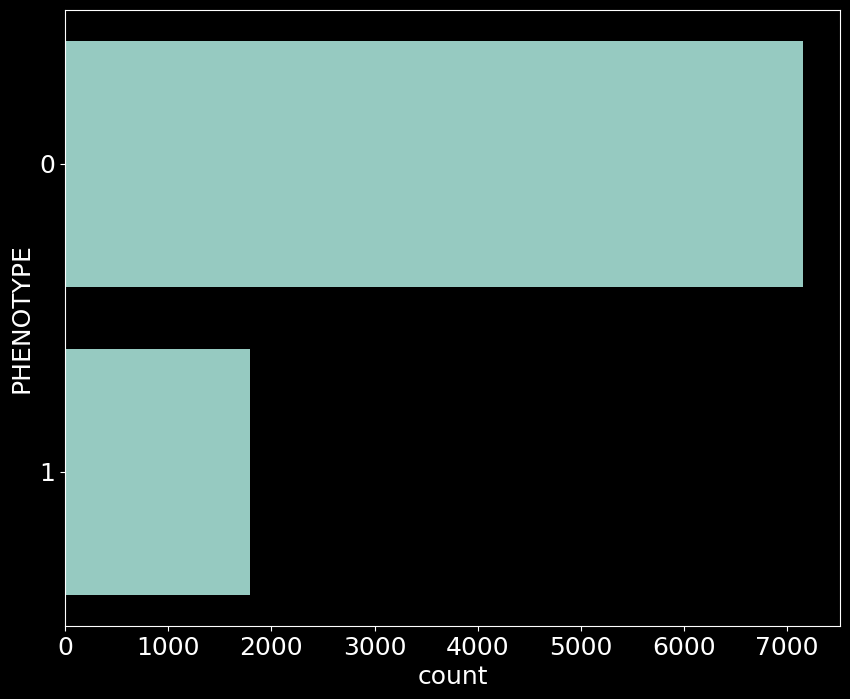

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.countplot(y = df_data.PHENOTYPE, ax = ax)
plt.show()

In [ ]:
grouped_data = df_data.iloc[:,1:].groupby(['PHENOTYPE']).mean().reset_index() #grouping based on resistance levels
print(grouped_data)

   PHENOTYPE     eccB2     eccB3    Rv2331     eccB4     eccB5   Rv2499c  \
0          0  0.073774  0.102976  0.041917  0.459410  0.080760  0.014811   
1          1  0.124720  0.065436  0.077181  0.708613  0.052013  0.013423   

     Rv2336      infA      infB  ...   Rv1836c    Rv1003   Rv2366c    Rv1006  \
0  0.132318  0.016487  0.217549  ...  0.151740  0.025150  0.310605  0.034372   
1  0.146532  0.010626  0.172819  ...  0.123043  0.011745  0.397651  0.087808   

    Rv0963c    Rv3651      mutY   Rv1703c      bacA   Rv1882c  
0  0.055051  0.129384  0.085511  0.024731  0.120302  0.044711  
1  0.026286  0.158277  0.072707  0.032998  0.088926  0.071029  

[2 rows x 3861 columns]


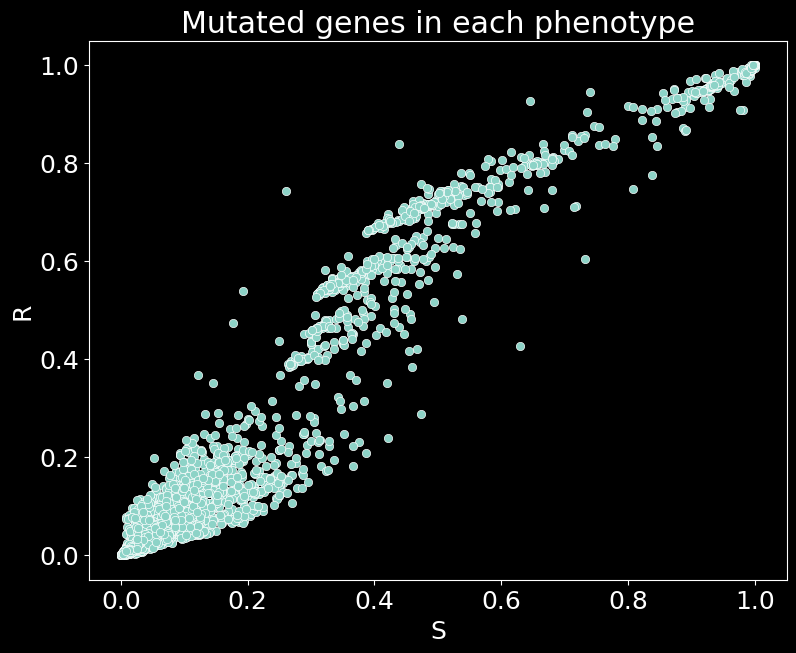

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.scatterplot(x = grouped_data.iloc[0,1:], y = grouped_data.iloc[1,1:], ax = ax)
ax.set(xlabel = "S", ylabel = "R", title = "Mutated genes in each phenotype")
plt.show()

In [ ]:
grouped_data_2func = df_data.iloc[:,0:].groupby(['PHENOTYPE']).agg(['sum', 'mean']).reset_index()


In [ ]:
grouped_data_2func

PHENOTYPE eccB1           eccB2           eccB3           Rv2331            \
              sum      mean   sum      mean   sum      mean    sum      mean   
0         0  1271  0.177588   528  0.073774   737  0.102976    300  0.041917   
1         1   545  0.304810   223  0.124720   117  0.065436    138  0.077181   

  eccB4  ... Rv3651           mutY           Rv1703c           bacA            \
    sum  ...    sum      mean  sum      mean     sum      mean  sum      mean   
0  3288  ...    926  0.129384  612  0.085511     177  0.024731  861  0.120302   
1  1267  ...    283  0.158277  130  0.072707      59  0.032998  159  0.088926   

  Rv1882c            
      sum      mean  
0     320  0.044711  
1     127  0.071029  

[2 rows x 7723 columns]

In [ ]:
select_sum = grouped_data_2func.columns.get_level_values(1).isin(['sum'])
select_mean = grouped_data_2func.columns.get_level_values(1).isin(['mean'])

In [ ]:
grouped_data_2func.iloc[0,select_sum].values

array([1271,  528,  737, ...,  177,  861,  320])

<ipython-input-39-71acae83edab>:6: RuntimeWarning: divide by zero encountered in divide
  probSoverR = probS/probR
<ipython-input-39-71acae83edab>:6: RuntimeWarning: invalid value encountered in divide
  probSoverR = probS/probR


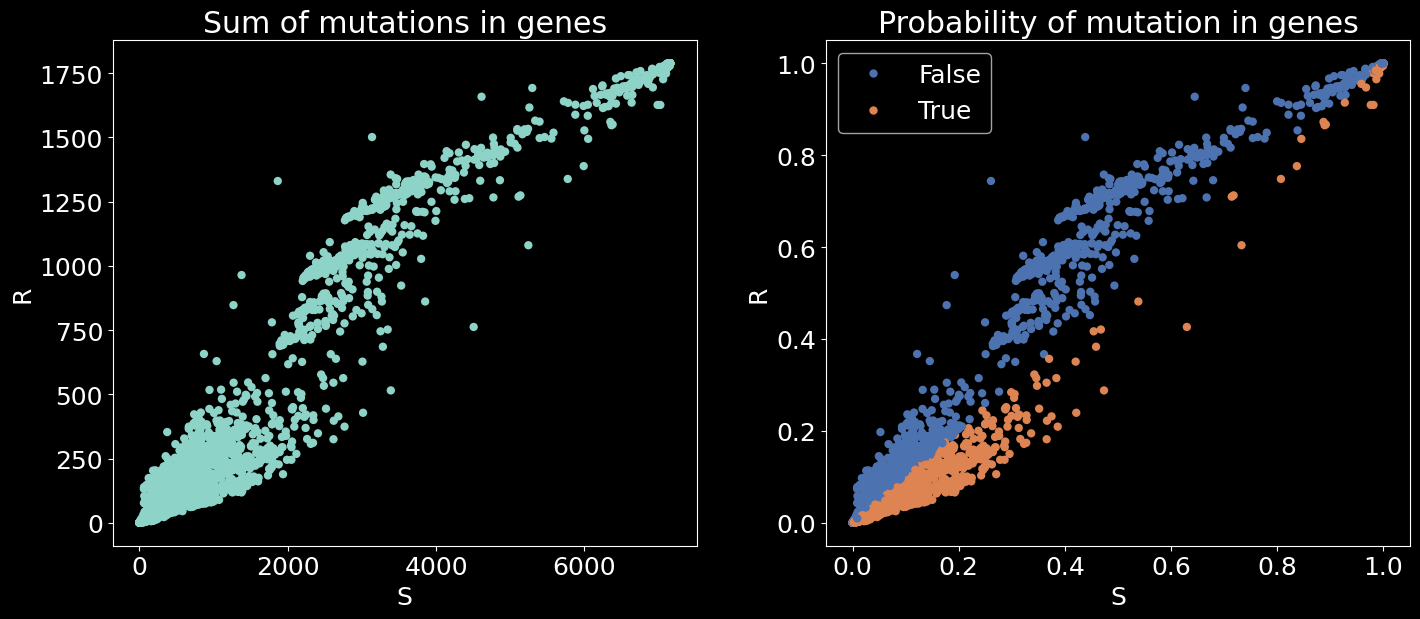

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (15,7))
sns.scatterplot(x = grouped_data_2func.loc[0,select_sum].values, y = grouped_data_2func.loc[1,select_sum].values, ax = ax[0], edgecolor = "none")
ax[0].set(xlabel = "S", ylabel = "R", title = "Sum of mutations in genes")
probS = grouped_data_2func.loc[0,select_mean].values
probR = grouped_data_2func.loc[1,select_mean].values
probSoverR = probS/probR
sns.scatterplot(x = probS, y = probR, ax = ax[1], hue = (probSoverR >= 1), edgecolor = "none", palette = "deep")
ax[1].set(xlabel = "S", ylabel = "R", title = "Probability of mutation in genes")
#ax[1].legend(['may not be importance', 'important'])
fig.tight_layout(pad = 2)
plt.show()

**Observation**: <br>
Since Tuberculosis is treated with multi-drug therapies, multiple mutated genes are selected. <br>
There is no gene that has a mutation unique to resistance isolates. <br>
This is also because mutations that would confer resistance to other drugs would be present in the strains sensitive and resistant to LEV. <br>
Resistance to one drug is independent of the other

## Identify genes that appear in both LEV R and LEV S strains

In [ ]:
genes = df_data.columns[0:-1]

In [ ]:
print(genes[(probS!=0) & (probR==0)]) # mutated genes present in susceptible class but not in Resistant class

Index(['Rv1590', 'Rv0750', 'Rv0628c', 'Rv2558', 'arsA', 'Rv3355c', 'Rv2438A',
       'PE_PGRS56', 'cmaA1', 'Rv1580c', 'Rv2979c', 'esxJ', 'Rv1587c', 'mce2A',
       'PPE18', 'lppA', 'lppB'],
      dtype='object')


**Observation**:
Genes may also be removed from the dataset since their roles. In totality, I will remove all genes that did not have a mutation in the Resistance phenotype

## Get correlation matrix of genes

In [ ]:
df_data.head()

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c,PHENOTYPE
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
corr_matrix = df_data.iloc[:,0:-1].corrwith(df_data.PHENOTYPE)

In [ ]:
df_data.iloc[:,0:-1]

,eccB1,eccB2,eccB3,Rv2331,eccB4,eccB5,Rv2499c,Rv2336,infA,infB,...,Rv1836c,Rv1003,Rv2366c,Rv1006,Rv0963c,Rv3651,mutY,Rv1703c,bacA,Rv1882c
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8940,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
8941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8942,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
8943,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
corr_matrix.values

array([ 0.12648454,  0.07346747, -0.05108718, ...,  0.02062732,
       -0.0394768 ,  0.04830406])

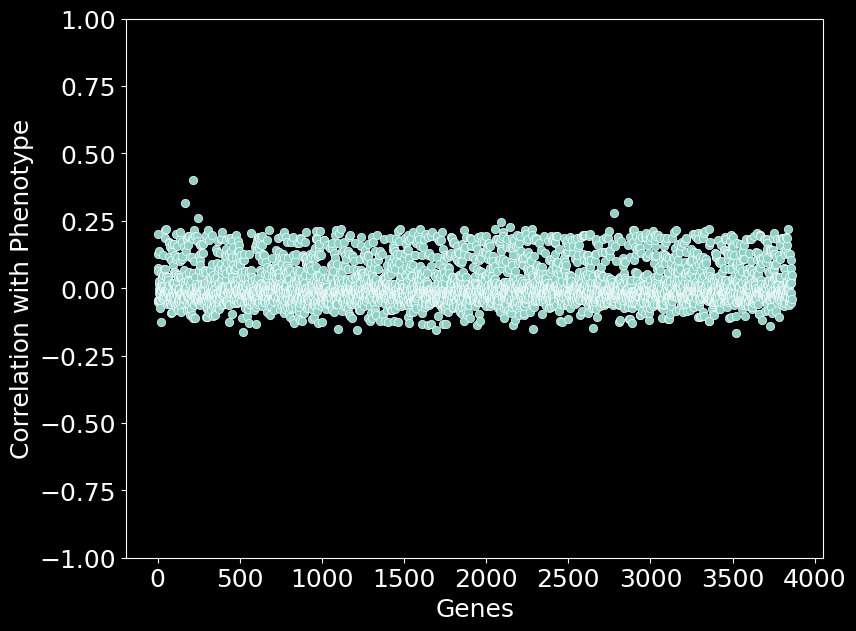

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.scatterplot(corr_matrix.values.flatten())
ax.set_ylim([-1, 1])
ax.set_xlabel("Genes")
ax.set_ylabel("Correlation with Phenotype")
plt.show()

## Plot the Entire Dataset - T-sne <br>
Instead of applying tsne on the entire dataset with 3000 genes, owing to computational expense, I first use TruncatedSVD and then employ tsne

In [ ]:
svd = TruncatedSVD(n_components = 100, n_iter = 7, random_state = 11) #calculated SVD for 100 components
svd.fit(df_data.iloc[:,1:-1])

TruncatedSVD(n_components=100, n_iter=7, random_state=11)

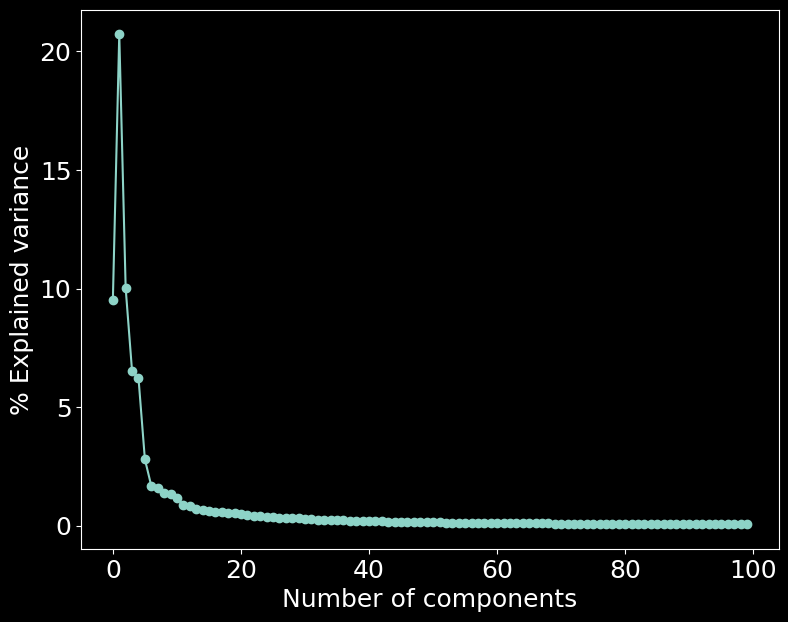

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
plt.plot(svd.explained_variance_ratio_*100, 'o-')
ax.set_xlabel("Number of components")
ax.set_ylabel("% Explained variance")
plt.show()

**Obervation**:
Using only 20 of these components to plot tsne plot to visualize the entire dataset

In [ ]:
svd_final = TruncatedSVD(n_components = 20, n_iter = 7, random_state = 11)
df_LEV_svd = svd_final.fit_transform(df_data.iloc[:,1:-1])
tsne = TSNE(n_components = 2, n_iter = 300)
tsne_results = tsne.fit_transform(df_LEV_svd)

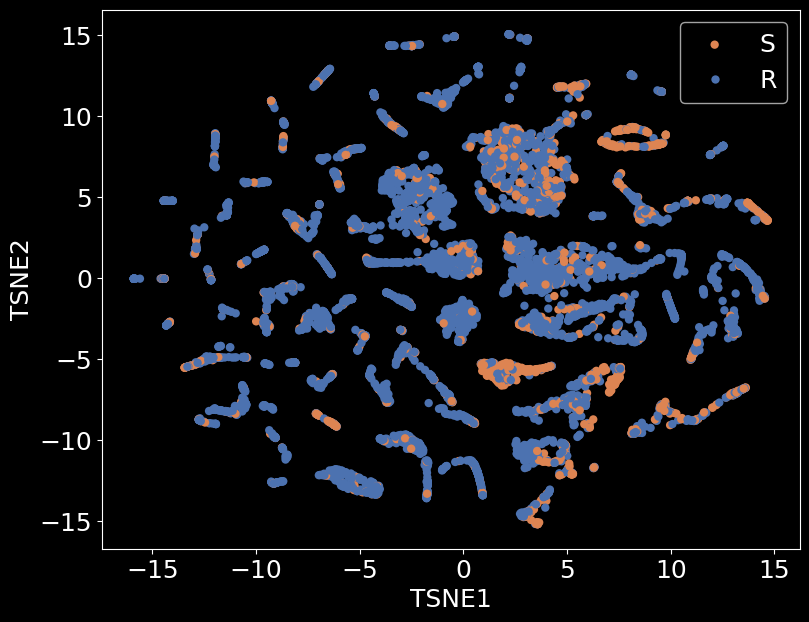

In [ ]:
fig, ax = plt.subplots(figsize = (9,7))
sns.scatterplot(x = tsne_results[:,0], y = tsne_results[:,1], hue = df_data.PHENOTYPE.values, ax = ax, palette = "deep", edgecolor = "none")
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.legend(['S', 'R'])
plt.show()

**Observation**: <br>
When points are clustered they are still together

In [ ]:
def get_val_train_curve(model, par, classification = False):
  par_name = list(par.keys()) # get the parameter names
  df = pd.DataFrame(model.cv_results_)# create dataframe from cv_results_
  fig, axes = plt.subplots(1,len(par_name), figsize = (10,8)) #define fig and axes
  fig.tight_layout(pad = 2) #increase the padding
  if classification: # if it was classification
    factor_mul = 1 #set to 1
    Error = "Accuracy"
  else:
    Error = "MSE"
    factor_mul = -1 #else set to -1. -1 is for mse

  if len(par_name) == 1: #if only one
    test_error = df['mean_test_score'] #get mean val_error from df
    std_test_error = df['std_test_score'] #get std of val_error from df
    train_error = df['mean_train_score'] #get train_error from df
    std_train_error = df['std_train_score'] #get std of train_error from df
    axes.plot(par[par_name[0]], factor_mul*test_error, label = "valid", lw = 2) #plot validation error
    axes.fill_between(par[par_name[0]], factor_mul*(test_error-std_test_error), factor_mul*(test_error+std_test_error), alpha = 0.2) #create std band around mean val_error
    axes.plot(par[par_name[0]], factor_mul*train_error, label = "train", lw = 2) #plot train_error
    axes.fill_between(par[par_name[0]], factor_mul*(train_error-std_train_error), factor_mul*(train_error+std_train_error), alpha = 0.2) #create std band around mean train_error
    axes.set_ylabel(Error)
  else: #else iterate
    for index, p in enumerate(par_name): #iterate over hyperparameters
      best_val = model.best_params_[p] #get the best value of one parameter
      test_error = df[df['param_'+str(p)] == best_val].loc[:,'mean_test_score'] # for the best value get the values of test error for other parameter
      std_test_error = df[df['param_'+str(p)] == best_val].loc[:,'std_test_score'] # for the best value get std of test error for other
      train_error = df[df['param_'+str(p)]== best_val].loc[:,'mean_train_score'] #for best value get values of train error for other
      std_train_error = df[df['param_'+str(p)]== best_val].loc[:,'std_train_score'] #for best value get values of std of train error for other
      axes[index].plot(par[par_name[1-index]], factor_mul*test_error, label = "valid", lw = 2) #plot test error
      axes[index].fill_between(par[par_name[1-index]], factor_mul*(test_error-std_test_error), factor_mul*(test_error+std_test_error), alpha = 0.2) #plot std as band around the mean
      axes[index].plot(par[par_name[1-index]], factor_mul*train_error, label = "train", lw = 2) #plot train error
      axes[index].fill_between(par[par_name[1-index]], factor_mul*(train_error-std_train_error), factor_mul*(train_error+std_train_error), alpha = 0.2) #plot std as band around the mean
      axes[index].set_xlabel(par_name[1-index])
    axes[0].set_ylabel(Error)


## Identify Duplicates


## Identify Correlated genes

# Baseline Score

In [ ]:
RF_model = RandomForestClassifier()
param_grid = {
    'max_depth': np.arange(2,20,3),
    'n_estimators': np.arange(100,200,10)

}
Grid_RF = GridSearchCV(RF_model,
                       param_grid,
                       scoring = 'balanced_accuracy',
                       cv = 5, #80:20 between train:validation
                       verbose = 2,
                       n_jobs = -1, #use the CPUs in the system
                       return_train_score = True
                       )
Grid_RF.fit(X_train, y_train)
print(f"Best Scores: {Grid_RF.best_score_}")
print(f"Best parameters: {Grid_RF.best_params_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Scores: 0.6841465942337723
Best parameters: {'max_depth': 17, 'n_estimators': 110}


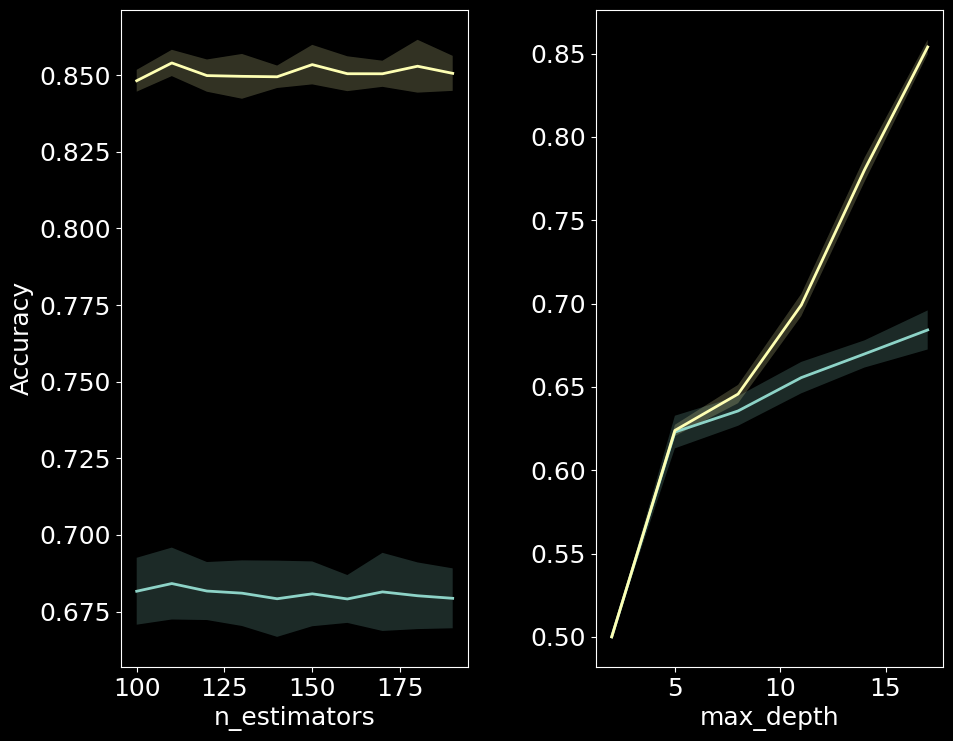

In [ ]:
get_val_train_curve(Grid_RF, param_grid, classification = True)

##Perform Clustering to see if some patterns emerge

## Identify genes that are important for resistance to other drugs

# Feature Engineering and Extraction

## Remove Genes associated with resistance to other drugs

## Remove Genes not associated with R of S of LEV

## Group genes into operons

# Machine Learning Model training

## Get baseline scores

## RandomForest and get feature importance + RFECV to reduce number of genes

## Neural Networks

## Convolution Neural Networks

# Deploy the app